# Transfer Learning: answers

## Step 0: Getting setup

### Imports

In [1]:
# PyTorch framework
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

# Model evaluation
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Basic libraries
from pathlib import Path
from PIL import Image
from typing import Tuple, Dict, List
import numpy as np
import random
import pathlib
import os
import time
import copy

### Set device

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Exercise 1: Prepare the train_dataset 

In [3]:
# Setup train path
image_path = Path("../datasets/Transport_Dataset")
train_dir = image_path / "train"

In [4]:
# Define the data transform 
train_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomAutocontrast(p = 0.2),
    transforms.ToTensor(), 
    transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                         std = [0.229, 0.224, 0.225]) 
 
])

# Use ImageFolder to create the train_dataset
train_data = datasets.ImageFolder(
    root = train_dir,  # Target folder of images
    transform = train_transform  # Transforms to perform on train data (images)
)

# Create the train_dataloader
train_dataloader = DataLoader(dataset = train_data, 
                              batch_size = 8, # Samples per batch
                              shuffle = True) # Shuffle training data

In [5]:
# Get class names as a list
class_names = train_data.classes
print("Class names (list):", class_names)

# Get class names as a dictionary
class_dict = train_data.class_to_idx
print("Class names (dictionary):", class_dict)

# Check the lengths
print("Length of train_data:", len(train_data))

Class names (list): ['airplanes', 'cars', 'ship']
Class names (dictionary): {'airplanes': 0, 'cars': 1, 'ship': 2}
Length of train_data: 3000


# 2. Getting a pretrained model

### Freeze model and change the output layer to suit our dataset

In [6]:
# Load a ResNet-18 model with weights pretrained on the ImageNet dataset
model = torchvision.models.resnet18(weights = 'IMAGENET1K_V1')

# Freeze the parameters of the model
for param in model.parameters():
    param.requires_grad = False
    
# Replace the FC layer with a classifier that has 3 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)

# Move the model to the specified device (GPU/CPU) for computation
model = model.to(DEVICE)

### Get a summary of our model with torchinfo.summary()

To learn more about our model, let's use `torchinfo`'s `summary()` [method](https://github.com/TylerYep/torchinfo#documentation).

To do so, we'll pass in:
 * `model` - the model we'd like to get a summary of.
 * `input_size` - the shape of the data we'd like to pass to our model. In our case the input size is `(batch_size, 3, 224, 224)`
 * `col_names` - the various information columns we'd like to see about our model. 
 * `col_width` - how wide the columns should be for the summary.
 * `row_settings` - what features to show in a row.

In [7]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [8]:
summary(model = model, 
        input_size = (8, 3, 224, 224), 
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width = 15,
        row_settings = ["var_names"]
) 

Layer (type (var_name))                  Input Shape     Output Shape    Param #         Trainable
ResNet (ResNet)                          [8, 3, 224, 224] [8, 3]          --              Partial
├─Conv2d (conv1)                         [8, 3, 224, 224] [8, 64, 112, 112] (9,408)         False
├─BatchNorm2d (bn1)                      [8, 64, 112, 112] [8, 64, 112, 112] (128)           False
├─ReLU (relu)                            [8, 64, 112, 112] [8, 64, 112, 112] --              --
├─MaxPool2d (maxpool)                    [8, 64, 112, 112] [8, 64, 56, 56] --              --
├─Sequential (layer1)                    [8, 64, 56, 56] [8, 64, 56, 56] --              False
│    └─BasicBlock (0)                    [8, 64, 56, 56] [8, 64, 56, 56] --              False
│    │    └─Conv2d (conv1)               [8, 64, 56, 56] [8, 64, 56, 56] (36,864)        False
│    │    └─BatchNorm2d (bn1)            [8, 64, 56, 56] [8, 64, 56, 56] (128)           False
│    │    └─ReLU (relu)             

> We observed that we trained only a small percentage (1,539) of the total number of network parameters (11,178,051) in the model. This enables faster training compared to retraining the entire network.

# 3. Fitting the model to data

## 3.1 Build a training loop

In [9]:
def train(model, criterion, optimizer, num_epochs = 20):
    size = len(train_dataloader.dataset)
    model.train()
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        for batch, (inputs, labels) in enumerate(train_dataloader):
            
            # Send data to GPU if available
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # 1. Forward pass
            outputs = model(inputs)
            
            # 2. Calculate loss (per batch)
            loss = criterion(outputs, labels)

            # 3. Backpropagation
            loss.backward()
            
            # 4. Optimizer step
            optimizer.step()
            
            # 5. Optimizer zero grad
            optimizer.zero_grad()

            # Print the loss per batch 
            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(inputs)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

### 3.2 Loss function and optimizer

In [10]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

### 3.3 Train and save the model

In [12]:
train(model, loss, optimizer, 5)

Epoch 0/4
----------
loss: 1.356185  [    8/ 3000]
loss: 0.650238  [  808/ 3000]
loss: 0.274277  [ 1608/ 3000]
loss: 0.194240  [ 2408/ 3000]
Epoch 1/4
----------
loss: 0.191331  [    8/ 3000]
loss: 0.323714  [  808/ 3000]
loss: 0.295586  [ 1608/ 3000]
loss: 0.048778  [ 2408/ 3000]
Epoch 2/4
----------
loss: 0.251818  [    8/ 3000]
loss: 0.164212  [  808/ 3000]
loss: 0.121152  [ 1608/ 3000]
loss: 0.124272  [ 2408/ 3000]
Epoch 3/4
----------
loss: 0.140745  [    8/ 3000]
loss: 0.026525  [  808/ 3000]
loss: 0.545546  [ 1608/ 3000]
loss: 0.018695  [ 2408/ 3000]
Epoch 4/4
----------
loss: 0.130328  [    8/ 3000]
loss: 0.045815  [  808/ 3000]
loss: 0.083775  [ 1608/ 3000]
loss: 0.059143  [ 2408/ 3000]


In [13]:
# Save the model
MODEL_PATH = "../data/models/resnet18_TL_TransportDataset.pth"
torch.save(model.state_dict(), MODEL_PATH)

# 4. Assessing the model performance

## 4.1 Prepare the test dataset

In [14]:
# Setup testing path
image_path = Path("../datasets/Transport_Dataset")
test_dir = image_path / "test"

# Define the data transform 
test_transform = transforms.Compose([
   transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                         std = [0.229, 0.224, 0.225]) 
])

# Use ImageFolder to create dataset
test_data = datasets.ImageFolder(
    root = test_dir,
    transform = test_transform  # Transforms to perform on test data (images)
)

# Create the dataloader
test_dataloader = DataLoader(dataset = test_data, 
                             batch_size = 8,  
                             shuffle = True) 

# Get class names as a list
class_names = test_data.classes
print("Class names (list):", class_names)

Class names (list): ['airplanes', 'cars', 'ships']


## 4.2 Load the trained model

In case you haven't completed the previous steps, you can utilize the model located in the following directory:

```
data/ 
    models/ 
        resnet18_TL_TransportDataset.pth
```

In [15]:
# Load a ResNet-18 model architecture
model = torchvision.models.resnet18()

# Replace the FC layer with a classifier that has 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)

# Move the model to the specified device
model.to(DEVICE)

# Load trained weights
MODEL_PATH = '../data/models/resnet18_TL_TransportDataset.pth'
model.load_state_dict(torch.load(MODEL_PATH, map_location = DEVICE))

<All keys matched successfully>

## 4.3 Build a testing loop

In [16]:
# Set the model to evaluation mode
model.eval()

# Lists to store true labels and predicted labels
y_true = []
y_pred = []

# Disable gradient computation
with torch.no_grad():
    for test_data in test_dataloader: # Iterate over the test dataloader to get test images and labels
        test_images, test_labels = (test_data[0].to(DEVICE), 
                                    test_data[1].to(DEVICE))
        # Forward pass through the model to get predictions
        output = model(test_images)
        
        # Compute the predicted labels by taking the argmax of the softmax output
        pred_label = torch.softmax(output, dim = 1).argmax(dim = 1)

        # Append the true labels and predicted labels to their respective lists
        y_true.append(test_labels.cpu())
        y_pred.append(pred_label.cpu())

# Convert the lists of true labels and predicted labels to NumPy arrays
y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()

## 4.4 Compute metrics

### Classification report

In [17]:
# Generate the classification report and print it
report = classification_report(y_true, 
                               y_pred, 
                               target_names = ["Airplanes","Cars", "Ships"], 
                               digits = 4)
print(report)

              precision    recall  f1-score   support

   Airplanes     1.0000    0.9894    0.9947       189
        Cars     0.9948    0.9948    0.9948       193
       Ships     0.9901    1.0000    0.9950       200

    accuracy                         0.9948       582
   macro avg     0.9950    0.9947    0.9948       582
weighted avg     0.9949    0.9948    0.9948       582



### Confusion matrix

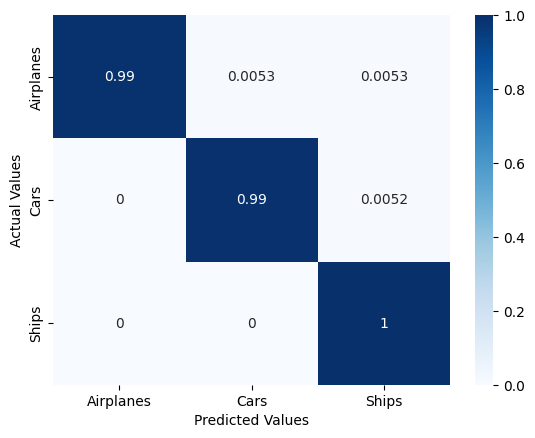

In [18]:
# Generate the confusion matrix
cmat = confusion_matrix(y_true, y_pred, normalize = 'true')

# Create a heatmap for the confusion matrix visualization
ax = sns.heatmap(cmat, annot = True, cmap = 'Blues')

# Set labels for x-axis and y-axis
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Set the labels 
ax.xaxis.set_ticklabels(["Airplanes","Cars", "Ships"])
ax.yaxis.set_ticklabels(["Airplanes","Cars", "Ships"])

# Display the visualization of the Confusion Matrix
plt.show()

The model achieves nearly perfect performance on the evaluation data. Moreover, we observed that in this scenario, using the ResNet-18 network with transfer learning produces superior results compared to training a simple model from scratch when using the same data preprocessing and hyperparameters during training.